# User In-State and Out-of-State Behavior Analysis

### Setting up enviroment

In [2]:
# Python Stuff
import pandas as pd
import numpy as np
import seaborn as sns
from math import sin, cos, sqrt, atan2, radians

# PySpark Stuff 
from pyspark.sql.functions import col, desc, avg
from pyspark.sql import functions as F

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Loading Data

In [4]:
table_b = 'red-formula-339716:gfds.yelp_business_basicdata'
df_b = spark.read.format('bigquery').option('table', table_b).load()

In [5]:
table_re = 'red-formula-339716:gfds.yelp_review'
df_re = spark.read.format('bigquery').option('table', table_re).load()

In [6]:
df_review_slim = df_re.select(['user_id', 'business_id'])
df_business_slim = df_b.select(['business_id', 'city', 'state'])
df_review_business = df_review_slim.join(df_business_slim, on = 'business_id', how = 'inner').dropna()

In [7]:
df_review_business.show(2)

+--------------------+--------------------+---------+-----+
|         business_id|             user_id|     city|state|
+--------------------+--------------------+---------+-----+
|y-vHCBFQCDMwzsMwJ...|6iyM-H6_bI13gl4Zn...| Portland|   OR|
|P0Ltl7wZFDlHofnPq...|FVk12H4Cz4DkRzl8N...|Beaverton|   OR|
+--------------------+--------------------+---------+-----+
only showing top 2 rows



### Figuring out where the users are

In [8]:
# Give user a home state based on the state they most reviewed in. 
# If a person made half of all reviews in the same state, consider him/her living in the state.

# Count review for each state
user_state_df = df_review_business.groupby(['user_id', 'state']).count().withColumnRenamed("count", "state_count")

# Count total review 
user_df = df_review_business.groupby(['user_id']).count().withColumnRenamed("count", "total_count")

# Caluculate each state's percentage
user_state_df = user_state_df.join(user_df, on = 'user_id', how = 'left')
user_state_df = user_state_df.withColumn('state_percentage', col("state_count") / col("total_count"))

Threshold = 0.50001
user_state_df = user_state_df.withColumn('local', F.when((col("state_percentage") > Threshold), 1).otherwise(0))

In [9]:
user_state_df.show(10)

+--------------------+-----+-----------+-----------+------------------+-----+
|             user_id|state|state_count|total_count|  state_percentage|local|
+--------------------+-----+-----------+-----------+------------------+-----+
|--0666UC6t7DJWO4m...|   FL|          1|          1|               1.0|    1|
|--0LWpVOR539pgBvl...|   MA|          1|          1|               1.0|    1|
|--19CSe_41_fEKvfV...|   CO|          1|          1|               1.0|    1|
|--2GHi3yi8D4yBuUY...|   OR|          2|          2|               1.0|    1|
|--2JSDM9cMaxm8CHX...|   CO|          1|          1|               1.0|    1|
|--56dSK1Y7agEMyIJ...|   TX|          1|          1|               1.0|    1|
|--5FEgQNB3_7Wtjxk...|   WA|          4|          6|0.6666666666666666|    1|
|--5FEgQNB3_7Wtjxk...|   OR|          2|          6|0.3333333333333333|    0|
|--9BvAldSQW8wmAn0...|   OR|          1|          1|               1.0|    1|
|--A8rRSzpXtQ0MzgY...|   MA|         10|         10|            

In [10]:
user_state_labels = user_state_df.select(['user_id', 'state']).where(user_state_df.local == 1)

### Figure out where the reviews came from

In [11]:
# For each review, give user state labels
df_re_us = df_re.select('user_id', 'business_id', 'stars').join(user_state_labels, on = 'user_id', how = 'left').withColumnRenamed("state", "user_state")
df_re_us = df_re_us.dropna()

In [12]:
df_re_us.show(3)

+--------------------+--------------------+-----+----------+
|             user_id|         business_id|stars|user_state|
+--------------------+--------------------+-----+----------+
|--0666UC6t7DJWO4m...|5xS76cdT7THG14H_W...|  1.0|        FL|
|--0LWpVOR539pgBvl...|QVnatPo7jCEh9FcKl...|  1.0|        MA|
|--19CSe_41_fEKvfV...|i7jMAf1cZJ9h1FRTQ...|  5.0|        CO|
+--------------------+--------------------+-----+----------+
only showing top 3 rows



In [13]:
# For each review, give business state labels
df_re_lb = df_re_us.join(df_b.select('business_id', 'state'), on = 'business_id', how = 'left').withColumnRenamed("state", "business_state")
df_re_lb.show(3)

+--------------------+--------------------+-----+----------+--------------+
|         business_id|             user_id|stars|user_state|business_state|
+--------------------+--------------------+-----+----------+--------------+
|5xS76cdT7THG14H_W...|--0666UC6t7DJWO4m...|  1.0|        FL|            FL|
|QVnatPo7jCEh9FcKl...|--0LWpVOR539pgBvl...|  1.0|        MA|            MA|
|i7jMAf1cZJ9h1FRTQ...|--19CSe_41_fEKvfV...|  5.0|        CO|            CO|
+--------------------+--------------------+-----+----------+--------------+
only showing top 3 rows



In [14]:
# See if review was from in state or out of state
df_re_lb = df_re_lb.withColumn('in_state', F.when((col("user_state") == col("business_state")), 1).otherwise(0))

In [15]:
df_re_lb.show(10)

+--------------------+--------------------+-----+----------+--------------+--------+
|         business_id|             user_id|stars|user_state|business_state|in_state|
+--------------------+--------------------+-----+----------+--------------+--------+
|5xS76cdT7THG14H_W...|--0666UC6t7DJWO4m...|  1.0|        FL|            FL|       1|
|QVnatPo7jCEh9FcKl...|--0LWpVOR539pgBvl...|  1.0|        MA|            MA|       1|
|i7jMAf1cZJ9h1FRTQ...|--19CSe_41_fEKvfV...|  5.0|        CO|            CO|       1|
|lAMX7ndl9sJh117Qh...|--2GHi3yi8D4yBuUY...|  4.0|        OR|            OR|       1|
|1jW2Voh5XE7Yt6ZV-...|--2GHi3yi8D4yBuUY...|  5.0|        OR|            OR|       1|
|IdY70ew8MHW_1rTvB...|--2JSDM9cMaxm8CHX...|  5.0|        CO|            CO|       1|
|ZHxrgZY4NAqtnsBuo...|--56dSK1Y7agEMyIJ...|  4.0|        TX|            TX|       1|
|huveiOZFjsFI_Aiq9...|--5FEgQNB3_7Wtjxk...|  4.0|        WA|            WA|       1|
|ggqr9BEklylICKl77...|--5FEgQNB3_7Wtjxk...|  2.0|        WA|     

In [16]:
df_re_lb.groupby('user_state').count().orderBy(desc("count")).show(10)

+----------+-------+
|user_state|  count|
+----------+-------+
|        MA|2053862|
|        TX|1483963|
|        OR|1414248|
|        GA|1116795|
|        FL|1087386|
|        BC| 601700|
|        OH| 421275|
|        CO| 131227|
|        WA|  98505|
|        CA|    162|
+----------+-------+
only showing top 10 rows



In [17]:
# Will be looking into the top 7
state_list = ["MA", "TX", "OR", "GA", "FL", "BC", "OH"]
df_re_lb = df_re_lb.where(df_re_lb.user_state.isin(state_list))
df_re_lb = df_re_lb.where(df_re_lb.business_state.isin(state_list))

In [18]:
df_re_lb_1 = df_re_lb.groupby('user_state').pivot('business_state').count().fillna(0)
pd_ubc = df_re_lb_1.select('user_state', "OR", "BC", "OH", "TX", "GA", "MA", "FL").toPandas()

In [29]:
df_re_lb_2 = df_re_lb.groupby('user_state').pivot('business_state').agg(avg("stars")).fillna(0)
pd_ubs = df_re_lb_2.select('user_state', "OR", "BC", "OH", "TX", "GA", "MA", "FL").toPandas()

### Create heatmap

In [20]:
# Create heatmap
# Count
pd_ubc = pd_ubc.set_index("user_state")
np.fill_diagonal(pd_ubc.values, 0)

In [21]:
pd_ubc

,OR,BC,OH,TX,GA,MA,FL
user_state,,,,,,,
OR,0,9141,1243,7767,4582,8517,4776
BC,8449,0,211,1348,862,2281,1609
OH,1195,372,0,1531,2345,2594,3238
TX,8743,2545,1668,0,6990,10070,7540
GA,3943,1552,2063,5687,0,9009,14810
MA,9272,3645,2570,10059,10252,0,14486
FL,3819,1874,2229,5727,14152,9535,0


In [25]:
sns.set(rc = {'figure.figsize':(15,8)})

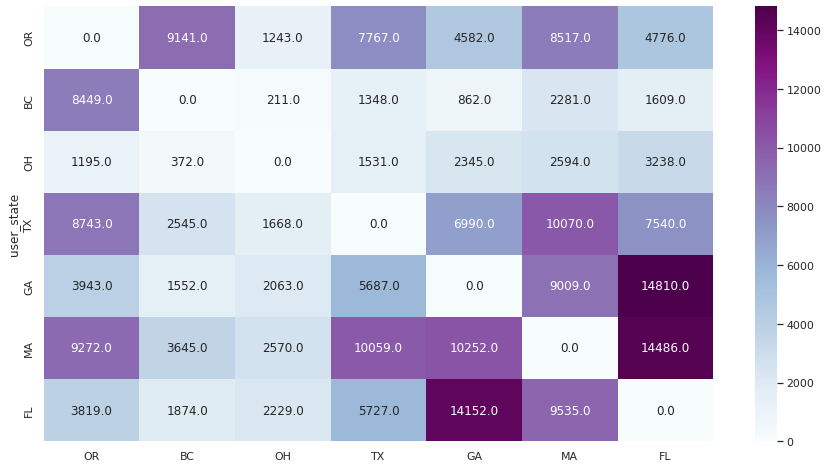

In [26]:
h = sns.heatmap(pd_ubc, annot=True,fmt=".1f", cmap="BuPu")
fig = h.get_figure()
fig.savefig("ubc.png") 

In [30]:
pd_ubs = pd_ubs.set_index("user_state")
pd_ubs

,OR,BC,OH,TX,GA,MA,FL
user_state,,,,,,,
OR,3.866465,3.956460,3.757039,4.001287,3.708206,3.802630,3.692002
BC,4.015150,3.607017,4.000000,3.968843,3.635731,3.760193,3.731510
OH,4.052720,4.077957,3.688640,3.937296,3.715139,3.833462,3.749846
TX,4.088185,4.008251,3.902278,3.822535,3.736767,3.811718,3.688064
GA,4.078620,3.932990,3.708677,3.979075,3.645420,3.765457,3.743147
MA,4.080457,3.975034,3.822957,4.000099,3.766290,3.643913,3.698537
FL,4.080649,4.074173,3.898609,4.011874,3.814655,3.843314,3.717402


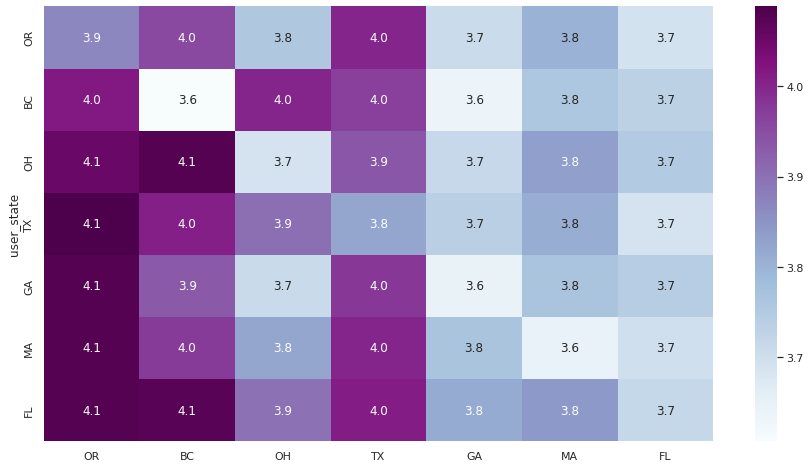

In [31]:
h = sns.heatmap(pd_ubs, annot=True, fmt=".1f", cmap="BuPu")
fig = h.get_figure()
fig.savefig("ubs.png") 